# 1.- Definir Problema

##### Predecir el precio del vuelo teniendo en consideración ciertos parametros

# 2.- Recuperar tabla desde la base de datos

##### Se realizó un web scripe a la pagina kayak.cl en el código presentado en el archivo prueba.ipynb que se guardó en la base de datos "master.db"

In [30]:
import pandas as pd
import sqlite3
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

In [31]:
conn = sqlite3.connect('../Database/master.db')
vuelos = 'vuelos' 
flights_total_data = pd.read_sql_query(f"SELECT * FROM {vuelos}", conn)
conn.close()

# 3.- Data Cleaning

In [32]:
flight_clean = flights_total_data.drop_duplicates()

##### Agregar las distancias 

In [33]:
df = pd.read_pickle('../Datos_cache/millas')
flight_clean1 = flight_clean.merge(df[['Destination', 'Distance (miles)']], on='Destination', how='left')

In [34]:
#Convirtiendo las distancias a int64
flight_clean1['Distance (miles)'] = flight_clean1['Distance (miles)'].astype('float')

##### Agregamos columna de reconocimiento de vuelos nacionales e internacionales

In [7]:
# Lee las tablas HTML en una lista de DataFrames
lista_nacionales = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Aeropuertos_de_Chile', header=1)
lista_nacionales=lista_nacionales[0]
lista_nacionales=lista_nacionales.drop(columns=['Ciudad o localidad','Región','OACI','Nombre del aeropuerto o aeródromo'],axis=1)

lista_nacionales = lista_nacionales.values.tolist()
lista_nac_aplanada = [elemento for sublista in lista_nacionales for elemento in sublista]
flight_clean1.loc[:, 'Tipo'] = flight_clean1['Destination'].apply(lambda x: 'Nacional' if x in lista_nac_aplanada else 'Internacional')

##### Agregamos columnas Fecha, Mes, Día de semana, Periodo y diferencia de días

In [35]:
#Filtrar fechas válidas
from datetime import datetime

def es_fecha_valida(fecha_str):
    try:
        datetime.strptime(fecha_str, "%Y-%m-%d")
        return True
    except ValueError:
        return False


df = pd.DataFrame(flight_clean1)
df_filtrado = flight_clean1[flight_clean1['StartDate'].apply(es_fecha_valida)]

# Convertir la columna 'Departure_date' a formato datetime
df_filtrado.loc[:,'Departure_Date'] = pd.to_datetime(df_filtrado['StartDate'])

# Convertir la columna 'DepartureTime' a formato datetime
df_filtrado.loc[:,'Dep_Hour'] = pd.to_datetime(df_filtrado['DepartureTime'])

# Agregar una columna 'Mes' que indique el nombre del mes de cada fila
df_filtrado.loc[:,'Dep_month'] = df_filtrado['Departure_Date'].dt.strftime('%B')


#extraer la fecha para convertirla en int32
df_filtrado["Start_dayN"]= pd.to_datetime(df_filtrado['Departure_Date'], format= "%d/%m/%Y").dt.day
df_filtrado["Start_monthN"]= pd.to_datetime(df_filtrado['Departure_Date'], format= "%d/%m/%Y").dt.month

# Agregar una columna "Dia_semana" que undique el dia de la semana en cada fila
df_filtrado.loc[:,'Week_Day'] = df_filtrado['Departure_Date'].dt.day_name()

# Definir los límites de los intervalos para las horas
bins = [-1, 5, 12, 19, 24]
# Agregar una columna 'Periodo' que clasifica las horas en 'mañana', 'tarde' o 'noche'
df_filtrado['Periodo'] = pd.cut(df_filtrado['Dep_Hour'].dt.hour,
                                bins=bins,
                                labels=['noche', 'mañana', 'tarde', 'noche'],
                                right=True,
                                include_lowest=True,
                                ordered=False)
#Agrega columna de diferencia de dias
df_filtrado.loc[:,'Days_to_come']  = (df_filtrado['Departure_Date'] - datetime(2023,11,10)).dt.days

/tmp/ipykernel_5450/3064753294.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:,'Departure_Date'] = pd.to_datetime(df_filtrado['StartDate'])
/tmp/ipykernel_5450/3064753294.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtrado.loc[:,'Dep_Hour'] = pd.to_datetime(df_filtrado['DepartureTime'])
/tmp/ipykernel_5450/3064753294.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

##### Cambiando TravelTime en variable numérica

In [36]:
import re
def convertir_a_horas(valor):
    # Utiliza una expresión regular para extraer horas y minutos
    match = re.match(r'(\d+)h (\d+)m', valor)
    
    if match:
        horas = int(match.group(1))
        minutos = int(match.group(2))
        
        # Convierte a horas y devuelve el resultado como float
        return horas + minutos / 60.0
    else:
        return None  # Manejo de casos donde el formato no es el esperado

# Aplica la función a la columna TimeTravel
df_filtrado['TravelTime'] = df_filtrado['TravelTime'].apply(convertir_a_horas)


/tmp/ipykernel_5450/1241071461.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['TravelTime'] = df_filtrado['TravelTime'].apply(convertir_a_horas)


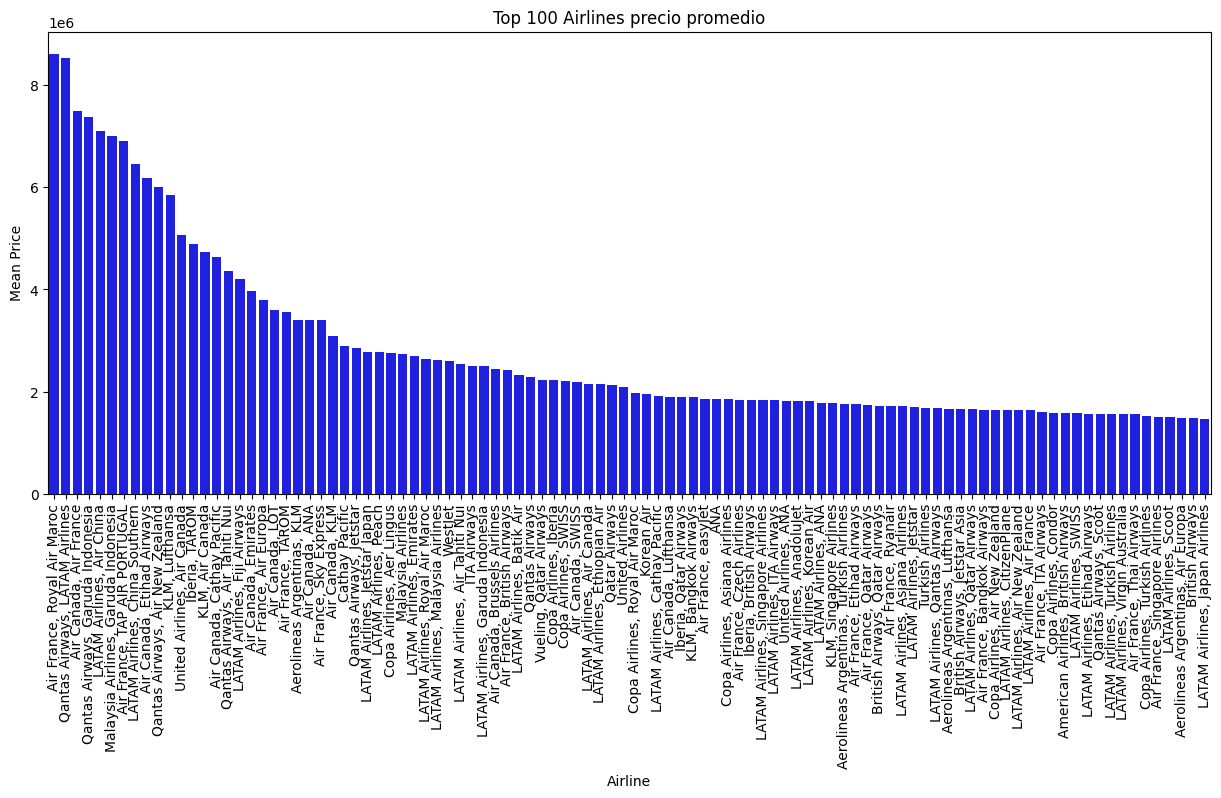

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

dfair = df_filtrado.groupby('Airline')['Price'].mean().sort_values(ascending=False)
dfair = dfair.head(100).reset_index()  # Resetting index to have 'Airline' as a column

# Creating a bar plot for the top 100 airlines by mean price
plt.figure(figsize=(15, 6))
sns.barplot(x='Airline', y='Price', data=dfair, color='blue')
plt.title('Top 100 Airlines precio promedio')
plt.xlabel('Airline')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)
plt.show()


In [37]:
df_filtrado.columns

Index(['Origin', 'Destination', 'StartDate', 'DepartureTime', 'ArrivalTime',
       'Price', 'Airline', 'Stops', 'LayoverAirports', 'TravelTime',
       'ClassType', 'Distance (miles)', 'Departure_Date', 'Dep_Hour',
       'Dep_month', 'Start_dayN', 'Start_monthN', 'Week_Day', 'Periodo',
       'Days_to_come'],
      dtype='object')

##### Borrado de segunda aerolinea 

In [58]:
df_filtrado.loc[:,'Airline'] = df_filtrado['Airline'].str.split(',').str[0]
df_filtrado['Airline'].nunique()

32

##### Dejar la columna Stops en datos numericos

In [59]:
#Convirtiendo escalas
df_filtrado['Stops'].value_counts()
# As this is case of Ordinal Categorical type we perform LabelEncoder
#we replace the values in key values 
df_filtrado.replace({'directo':0,'1 escala':1,'2 escalas':2,'3 escalas':3},inplace=True)

/tmp/ipykernel_5450/1830182514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.replace({'directo':0,'1 escala':1,'2 escalas':2,'3 escalas':3},inplace=True)


Variables categóricas

In [20]:
#Airline
#metodo one-hot-encoding
Airline = df_filtrado[["Airline"]]
Airline = pd.get_dummies(df_filtrado['Airline'],drop_first=True)
#Aplicando un lambda para que no salga true/false
Airline = Airline.applymap(lambda x: 1 if x ==1 else 0)

C:\Users\ivesc\AppData\Local\Temp\ipykernel_3184\1669994241.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Airline = Airline.applymap(lambda x: 1 if x ==1 else 0)


In [ ]:
#Destination
#metodo one-hot-encoding
Destination = pd.get_dummies(df_filtrado["Destination"], drop_first = True)
Destination = pd.get_dummies(Destination, drop_first = True)
Destination = Destination.applymap(lambda x: 1 if x ==1 else 0)

C:\Users\ivesc\AppData\Local\Temp\ipykernel_27832\3617653813.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Destination = Destination.applymap(lambda x: 1 if x ==1 else 0)


In [ ]:
df_dest = pd.concat([df_filtrado, Destination], axis=1)

In [ ]:
df_air = pd.concat([df_filtrado, Airline], axis=1)

In [ ]:
df_master = pd.concat([df_filtrado, Airline, Destination], axis = 1 )

In [ ]:
dfives= df_master.drop(['Destination','LayoverAirports','StartDate','Origin','Departure_Date','DepartureTime','ArrivalTime','Airline'],axis=1)

In [ ]:
dfives.head(1)

,Price,Stops,TravelTime,ClassType,Distance (miles),Start_dayN,Start_monthN,Periodo,Days_to_come,Aerolineas Argentinas,...,PRG,RIO,ROM,SAN,SDF,SFO,SYD,VIE,ZCO,ZRH
0,257997.0,2,31.083333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfives['Periodo'].replace(['mañana', 'noche', 'tarde'],
                        [0,1,2], inplace=True)

dfives['ClassType'].replace(['AM Plus','AM Plus Flex','Basic','Blue Basic','Business','Business Class (tarifa flexible)','Business Class (tarifa más baja)','Business Leisure','Business Special','Business XXL','Business Óptima','BusinessFly','Básica','Cabina principal','Cabina principal Semi-Flex','Cabina principal flex','Classic','Classic Flex','Comfort+','Delta One','Delta One reembolsable','Descuento','Eco Flex','Eco Flex Plus','Eco Special','EcoFly','Economy (parcialmente reembolsable)','Economy Classic','Economy Comfort','Economy Convenience','Economy Flex','Economy Light','Economy M','Economy S','Economy Sale','Economy Saver','Economy Superlight','Economy XS','Económica (reembolsable)','Económica Fully Flex','Económica Premium Fully Flex','Económica Select','Económica básica','Económica estándar','Económica pref.','Ejecutiva','Ejecutiva Flagship','Ejecutiva Flagship flexible','Ejecutiva Fully Flex','Ejecutiva flexible','Ejecutiva prémium plus','Ejecutiva/Primera','Flex','Flexible','Full','Go Basic','Go Standard','Latitude','Light','Main reembolsable','Mixta','Premier','Premium Business','Premium Economy (tarifa flexible)','Premium Economy (tarifa más baja)','Premium Standard','Promo','Red e-Deal','Saver','Semi-Flexible','Standard','Turista','Turista Premium Óptima','Turista superior','Value','Óptima'
], [1,1,0,0,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1
],inplace=True)

mylist = list(dfives.select_dtypes(include=['object']).columns)
dfives.drop(mylist,axis=1,inplace=True)

columnas_datetime = list(dfives.select_dtypes(include='datetime64').columns)
dfives.drop(columnas_datetime, axis=1, inplace=True)
dfives = dfives.dropna()

In [ ]:
dfives

,Price,Stops,TravelTime,ClassType,Distance (miles),Start_dayN,Start_monthN,Periodo,Days_to_come,Aerolineas Argentinas,...,PRG,RIO,ROM,SAN,SDF,SFO,SYD,VIE,ZCO,ZRH
0,257997.0,2,31.083333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
1,346180.0,1,16.366667,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
2,315902.0,2,15.333333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
3,891353.0,0,9.583333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
4,733115.0,1,13.833333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33993,3728847.0,2,25.166667,0,7792.000000,1,11,0,357,0,...,0,0,0,0,0,0,0,0,0,0
33994,3751107.0,2,25.166667,0,7792.000000,1,11,0,357,0,...,0,0,0,0,0,0,0,0,0,0
33995,3751107.0,2,28.916667,0,7792.000000,1,11,0,357,0,...,0,0,0,0,0,0,0,0,0,0
33996,729347.0,2,24.250000,0,7792.000000,1,11,0,357,0,...,0,0,0,0,0,0,0,0,0,0


# ------------------ Selección USA ----------------

In [39]:
df_filtrado['Destination'].unique()

array(['ATL', 'DEN', 'SAN', 'SFO', 'JFK', 'BOS', 'IAD', 'MIA', 'PAR',
       'CCS', 'BUE', 'MAD', 'RIO', 'LIM', 'LAX', 'ORD', 'DFW', 'LAS',
       'MCO', 'PHL', 'LGA', 'PDX', 'HNL', 'DTW', 'CLT', 'BNA', 'AUS',
       '\tDFW', 'EWR', 'PHX', 'MEM', 'SDF', 'CVG', 'LSC', 'CCP', 'ZCO',
       'ARI', 'IQQ', 'ANF', 'AEP', 'FCO', 'LIS', 'BCN', 'BER', 'AMS',
       'CRL', 'VIE', 'PRG', 'ARN', 'BUD', 'BUH', 'ATH', 'BGO', 'ZRH',
       'LON', 'IST', 'BHD', 'SYD', 'AKL', 'KIX', 'HKT', 'DPS', 'ROM',
       'FRA'], dtype=object)

In [40]:
df_usa = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Aeropuertos_m%C3%A1s_importantes_de_Estados_Unidos')
df_usa = df_usa[1]
df_usa= df_usa['Código IATA'].to_list()

In [60]:
df_filtrado['Destination'] = df_filtrado['Destination'].astype(str)

df_filtrado['pais'] = 'otro'
df_filtrado.loc[df_filtrado['Destination'].isin(df_usa), 'pais'] = 'usa'

/tmp/ipykernel_5450/87425956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Destination'] = df_filtrado['Destination'].astype(str)
/tmp/ipykernel_5450/87425956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['pais'] = 'otro'


In [61]:
df_filtrado_usa= df_filtrado[df_filtrado['pais']=='usa']

In [62]:
df_filtrado_usa.columns

Index(['Origin', 'Destination', 'StartDate', 'DepartureTime', 'ArrivalTime',
       'Price', 'Airline', 'Stops', 'LayoverAirports', 'TravelTime',
       'ClassType', 'Distance (miles)', 'Departure_Date', 'Dep_Hour',
       'Dep_month', 'Start_dayN', 'Start_monthN', 'Week_Day', 'Periodo',
       'Days_to_come', 'pais'],
      dtype='object')

In [63]:
df_filtrado_usa['Periodo'].replace(['mañana', 'noche', 'tarde'],
                        [0,1,2], inplace=True)

df_filtrado_usa['ClassType'].replace(['AM Plus','AM Plus Flex','Basic','Blue Basic','Business','Business Class (tarifa flexible)','Business Class (tarifa más baja)','Business Leisure','Business Special','Business XXL','Business Óptima','BusinessFly','Básica','Cabina principal','Cabina principal Semi-Flex','Cabina principal flex','Classic','Classic Flex','Comfort+','Delta One','Delta One reembolsable','Descuento','Eco Flex','Eco Flex Plus','Eco Special','EcoFly','Economy (parcialmente reembolsable)','Economy Classic','Economy Comfort','Economy Convenience','Economy Flex','Economy Light','Economy M','Economy S','Economy Sale','Economy Saver','Economy Superlight','Economy XS','Económica (reembolsable)','Económica Fully Flex','Económica Premium Fully Flex','Económica Select','Económica básica','Económica estándar','Económica pref.','Ejecutiva','Ejecutiva Flagship','Ejecutiva Flagship flexible','Ejecutiva Fully Flex','Ejecutiva flexible','Ejecutiva prémium plus','Ejecutiva/Primera','Flex','Flexible','Full','Go Basic','Go Standard','Latitude','Light','Main reembolsable','Mixta','Premier','Premium Business','Premium Economy (tarifa flexible)','Premium Economy (tarifa más baja)','Premium Standard','Promo','Red e-Deal','Saver','Semi-Flexible','Standard','Turista','Turista Premium Óptima','Turista superior','Value','Óptima'
], [1,1,0,0,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1
],inplace=True)

/tmp/ipykernel_5450/2418891405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_usa['Periodo'].replace(['mañana', 'noche', 'tarde'],
/tmp/ipykernel_5450/2418891405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_usa['ClassType'].replace(['AM Plus','AM Plus Flex','Basic','Blue Basic','Business','Business Class (tarifa flexible)','Business Class (tarifa más baja)','Business Leisure','Business Special','Business XXL','Business Óptima','BusinessFly','Básica','Cabina principal','Cabina principal Semi-Flex','Cabina principal flex','Classic','Classic Flex','Comfort+','Delta One','Delta One reemb

In [64]:
df_filtrado_usa = df_filtrado_usa[['Destination','Airline','Price','Stops','TravelTime','ClassType','Distance (miles)','Start_dayN','Start_monthN','Periodo','Days_to_come']]

In [65]:
df_filtrado_usa.replace({'directo':0,'1 escala':1,'2 escalas':2,'3 escalas':3},inplace=True)

In [66]:
Airline = pd.get_dummies(df_filtrado_usa['Airline'],drop_first=True)
Destination = pd.get_dummies(df_filtrado_usa["Destination"], drop_first = True)
Airline = Airline.astype(int)
Destination = Destination.astype(int)

In [67]:
df_filtrado_usa = pd.concat([df_filtrado_usa, Airline, Destination], axis = 1 )

In [68]:
df_filtrado_usa.dropna(inplace=True)
df_filtrado_usa = df_filtrado_usa.drop('Destination', axis=1)
df_filtrado_usa = df_filtrado_usa.drop('Airline', axis=1)
df_filtrado_usa

,Price,Stops,TravelTime,ClassType,Distance (miles),Start_dayN,Start_monthN,Periodo,Days_to_come,Aeromexico,...,LAX,LGA,MCO,MIA,ORD,PDX,PHL,PHX,SAN,SFO
0,257997,2,31.083333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
1,346180,1,16.366667,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
2,315902,2,15.333333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
3,891353,0,9.583333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
4,733115,1,13.833333,0,4727.897651,11,12,1,31,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21149,288098,1,17.416667,0,4148.727949,21,10,1,346,0,...,0,0,0,1,0,0,0,0,0,0
21150,288098,1,18.916667,0,4148.727949,21,10,2,346,0,...,0,0,0,1,0,0,0,0,0,0
21151,348631,2,16.833333,0,4148.727949,21,10,1,346,0,...,0,0,0,1,0,0,0,0,0,0
21152,1026887,2,19.333333,0,4148.727949,21,10,0,346,0,...,0,0,0,1,0,0,0,0,0,0


# 4.- Exploratory Data Analysis (EDA)

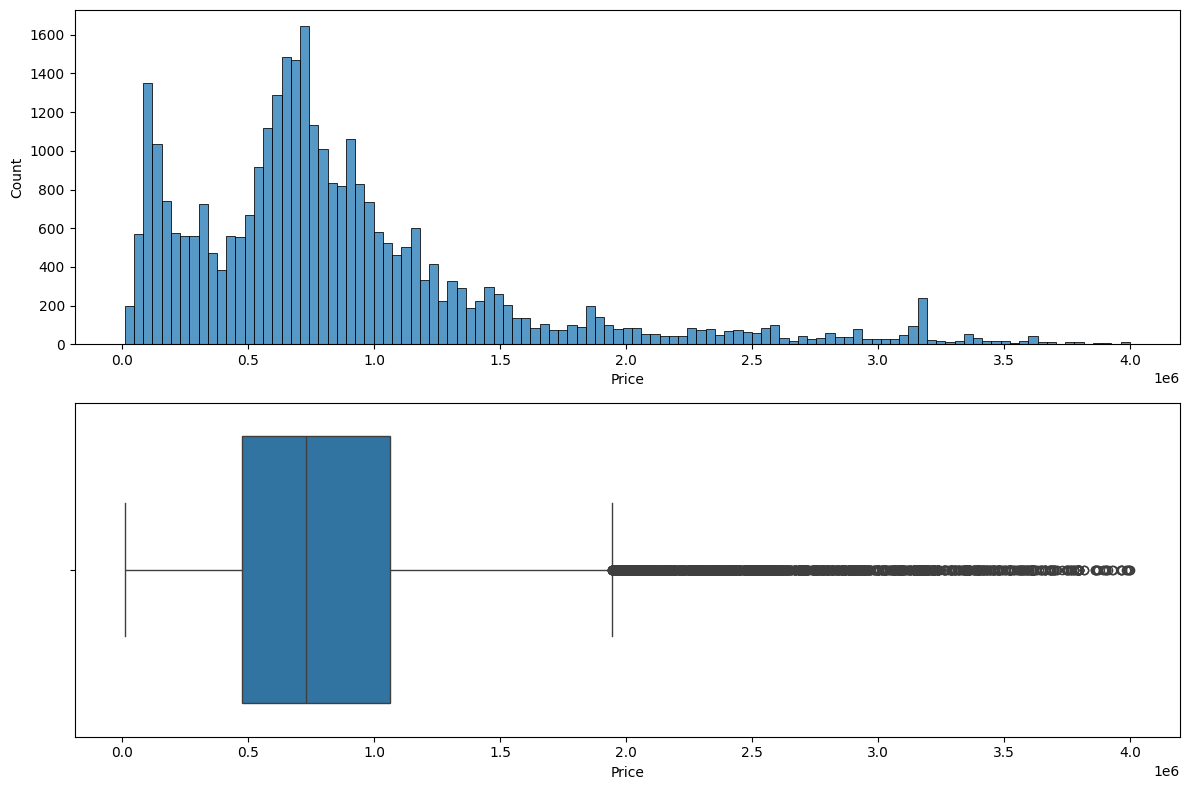

In [160]:
#Promedio Outliers
plt.style.use('default')
def plot(data, col, figsize_horizontal=8, figsize_vertical=10):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figsize_horizontal, figsize_vertical))

    sns.histplot(data[col], ax=ax1)

    sns.boxplot(x=data[col], orient='h', ax=ax2)
    
    plt.tight_layout()

plot(df_filtrado, 'Price', figsize_horizontal=12, figsize_vertical=8)

plt.show()

In [132]:
#Se dropean todos cuales los precios sean mayores a 4M
dfives['Price']=np.where(dfives['Price']>=4000000,dfives['Price'].median(),dfives['Price'])
df_filtrado['Price']=np.where(df_filtrado['Price']>=4000000,dfives['Price'].median(),df_filtrado['Price'])

C:\Users\ivesc\AppData\Local\Temp\ipykernel_27832\2501608917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Price']=np.where(df_filtrado['Price']>=4000000,dfives['Price'].median(),df_filtrado['Price'])


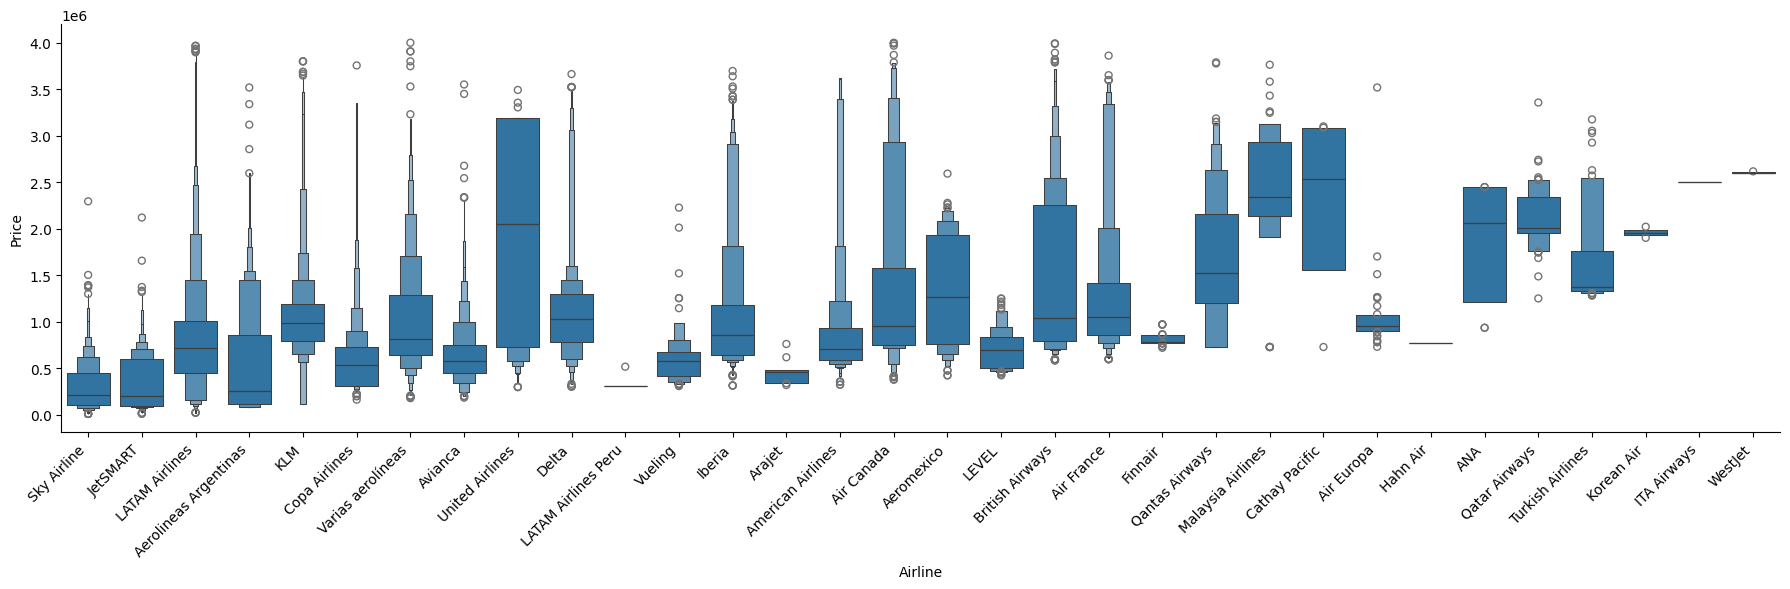

In [161]:
sns.catplot(y = "Price", x = "Airline", data = df_filtrado.sort_values("Price", ascending = True), kind="boxen", height = 6, aspect = 3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

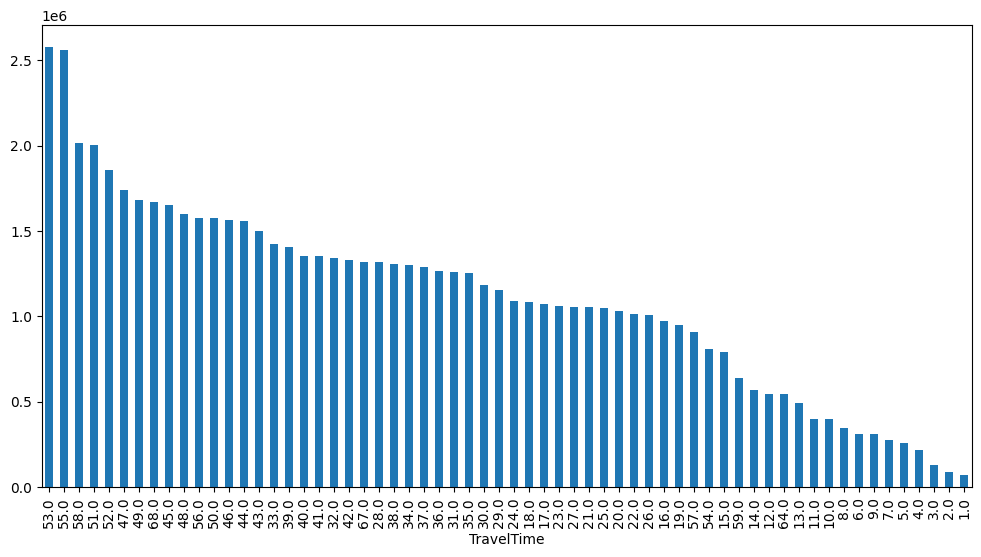

In [162]:
#Precios en funciosn de vuelo
plt.figure(figsize=(12, 6))

df_filtrado.loc[:, 'TravelTime'] = df_filtrado['TravelTime'].astype(int)
df1 = df_filtrado.groupby(['TravelTime'])['Price'].mean().sort_values(ascending=False)
df1.plot(kind='bar')
plt.show()

##### Precios en función del destino

C:\Users\ivesc\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


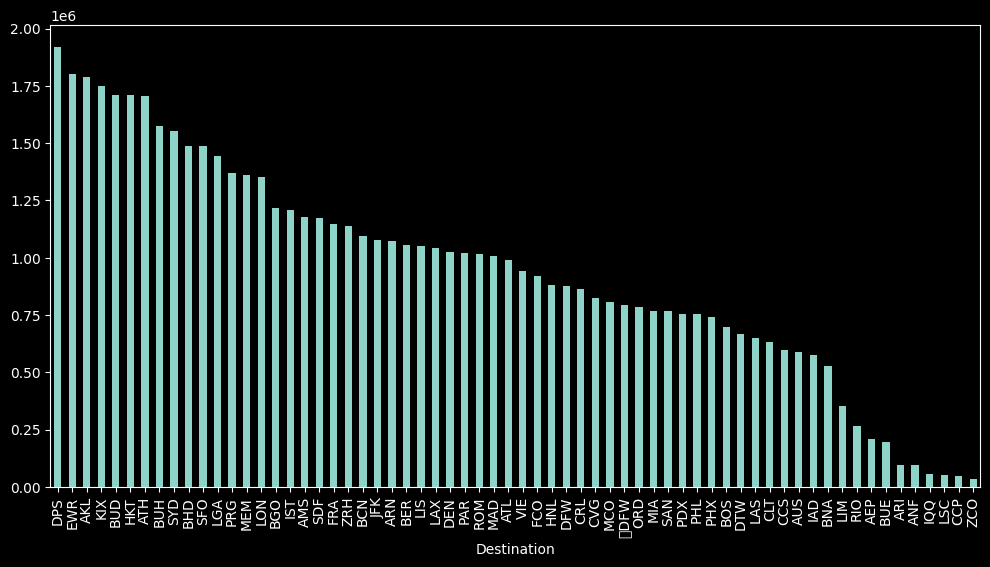

In [135]:
plt.figure(figsize=(12,6))

df1 = df_filtrado.groupby(['Destination'])['Price'].mean().sort_values(ascending=False)
df1.plot(kind='bar')

plt.show()

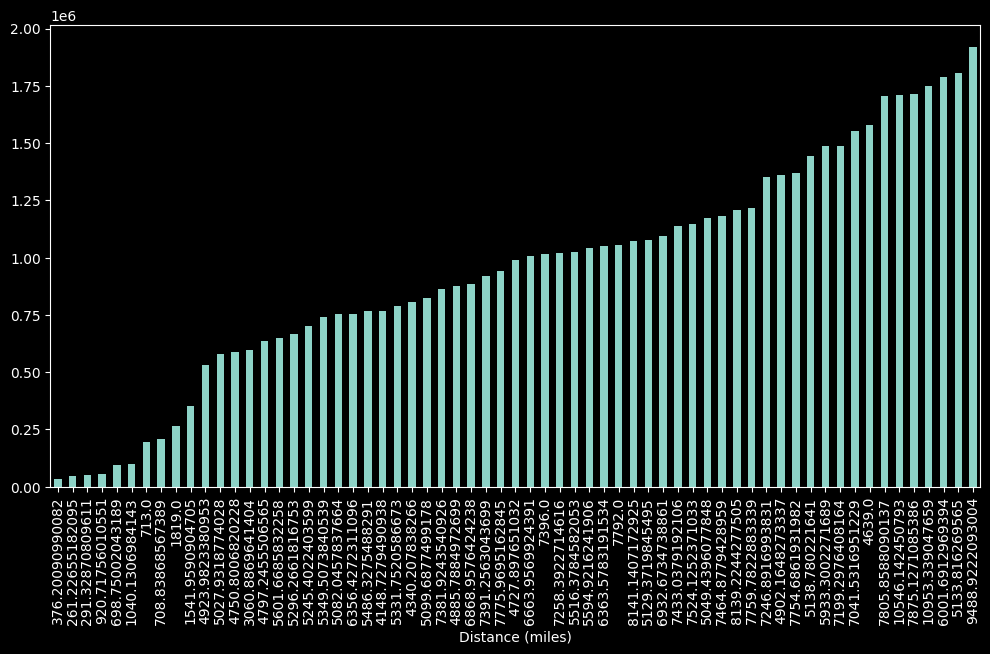

In [136]:
#Precios en funcion a distancia
plt.figure(figsize=(12,6))

df1 = df_filtrado.groupby(['Distance (miles)'])['Price'].mean().sort_values(ascending=True)
df1.plot(kind='bar')

plt.show()

##### Precio en función del mes, día de la semana y paradas

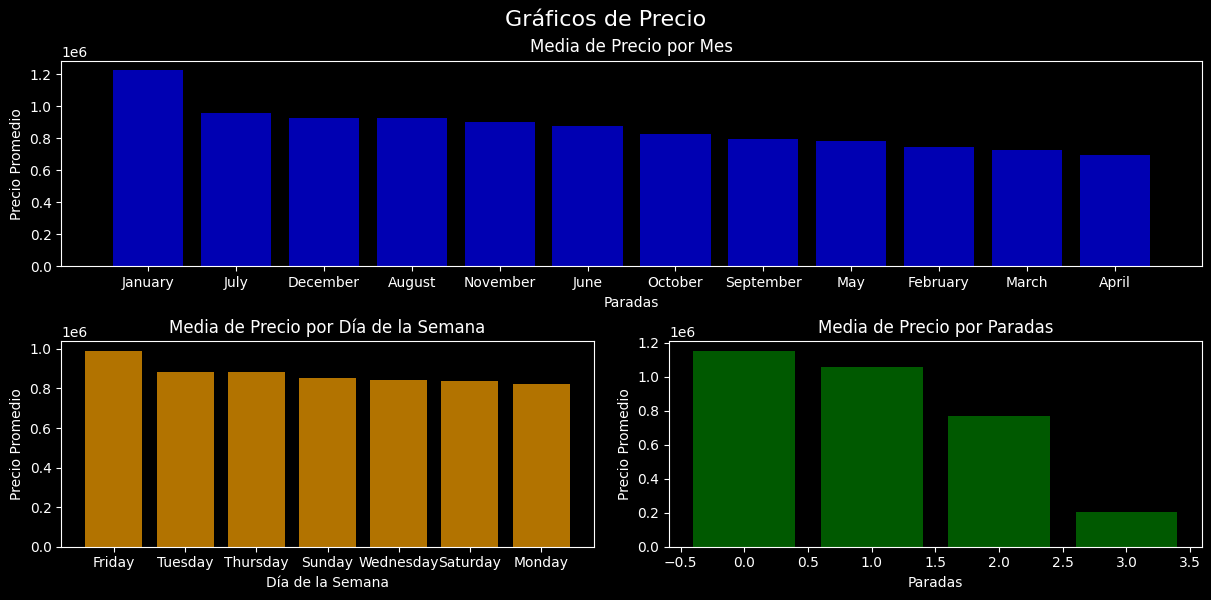

In [137]:
df1 = df_filtrado.groupby(['Stops'])['Price'].mean().sort_values(ascending=False)
df1 = df1.reset_index() 

df2 = df_filtrado.groupby(['Week_Day'])['Price'].mean().sort_values(ascending=False)
df3 = df_filtrado.groupby(['Dep_month'])['Price'].mean().sort_values(ascending=False)

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
spec = fig.add_gridspec(3, 2, height_ratios=[2, 2, 4])

# Grafico 1 en la parte superior izquierda (Stops)
ax0 = fig.add_subplot(spec[0, :])
ax0.bar(df3.index, df3.values, color='blue', alpha=0.7)
ax0.set_title('Media de Precio por Mes')
ax0.set_xlabel('Paradas')
ax0.set_ylabel('Precio Promedio')

# Grafico 2 en la parte superior derecha (Día de la semana)
ax1 = fig.add_subplot(spec[1, 0])
ax1.bar(df2.index, df2.values, color='orange', alpha=0.7)
ax1.set_title('Media de Precio por Día de la Semana')
ax1.set_xlabel('Día de la Semana')
ax1.set_ylabel('Precio Promedio')

# Grafico 3 abajo que abarque todo el espacio (Mes)
ax2 = fig.add_subplot(spec[1, 1:])
ax2.bar(df1.index, df1['Price'], color='green', alpha=0.7)  
ax2.set_title('Media de Precio por Paradas')
ax2.set_xlabel('Paradas')
ax2.set_ylabel('Precio Promedio')

# Ajustar el diseño para evitar superposiciones
fig.suptitle('Gráficos de Precio', fontsize=16)

# Mostrar el gráfico
plt.show()


##### Precios en función de la aerolinea

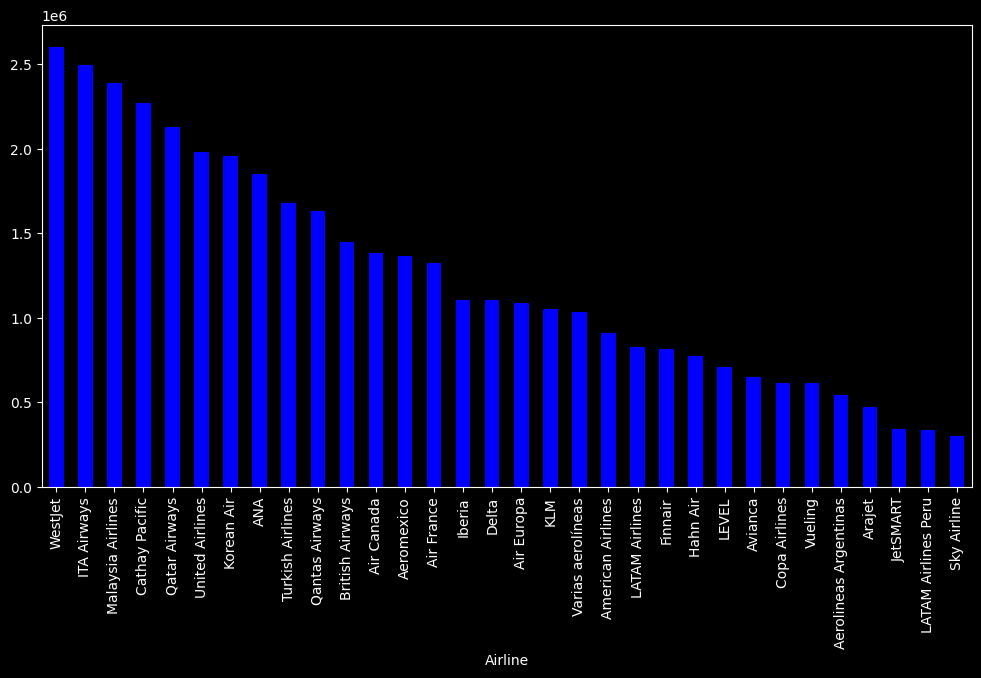

In [138]:
# Agrupa y calcula el promedio de los precios para cada aerolínea
df5 = df_filtrado.groupby(['Airline'])['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
df5.plot(kind='bar', color='blue')
plt.show()


##### Precios en función de tipo clase

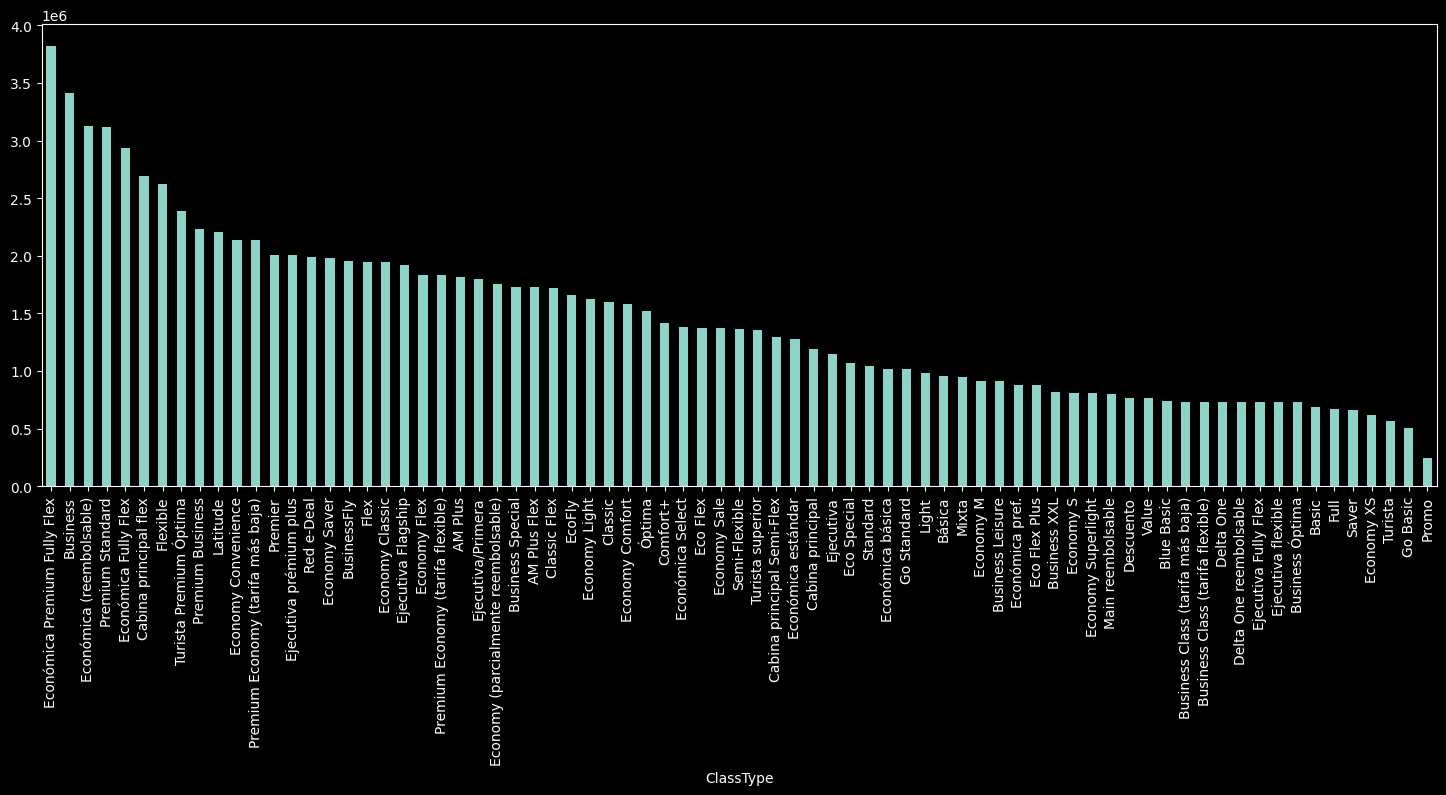

In [139]:
plt.figure(figsize=(18,6))

df1 = df_filtrado.groupby(['ClassType'])['Price'].mean().sort_values(ascending=False)
df1.plot(kind='bar')

plt.show()

<Axes: xlabel='Dep_month', ylabel='Price'>

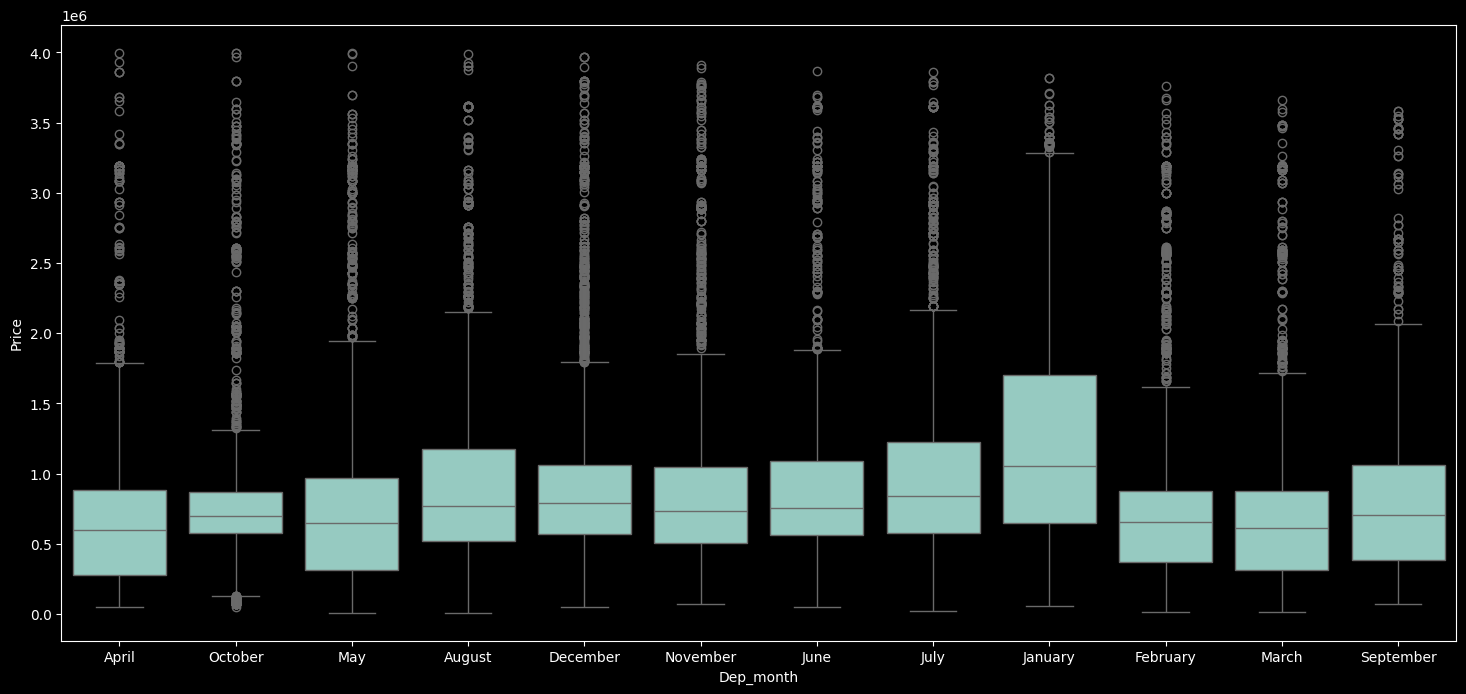

In [140]:
plt.figure(figsize=(18,8))
sns.boxplot(x='Dep_month',y='Price',data=df_filtrado.sort_values('Price',ascending=False))

c:\Users\ivesc\anaconda3-1\envs\airline\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 9 (	) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\ivesc\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


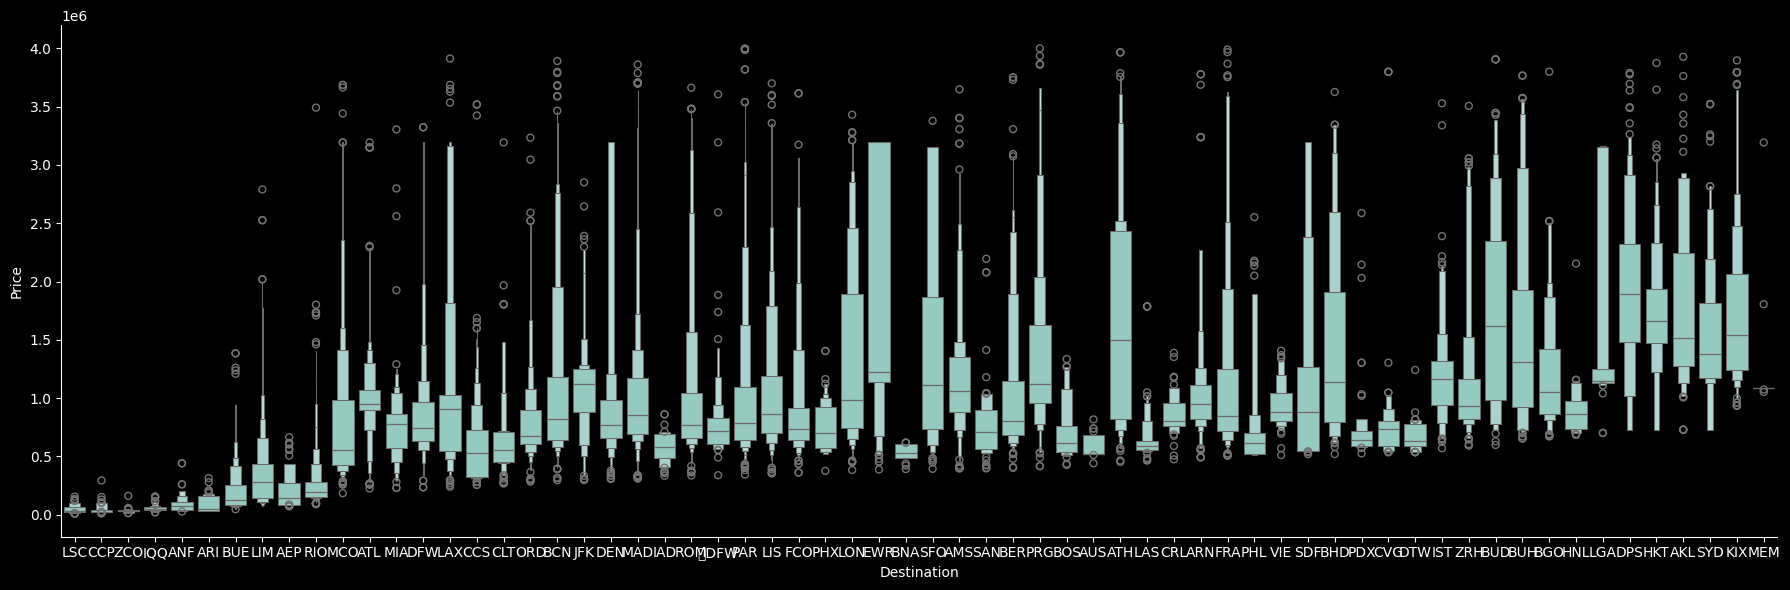

In [141]:
sns.catplot(y = "Price", x = "Destination", data = df_filtrado.sort_values("Price", ascending = True), kind="boxen", height = 6, aspect = 3)
plt.show()

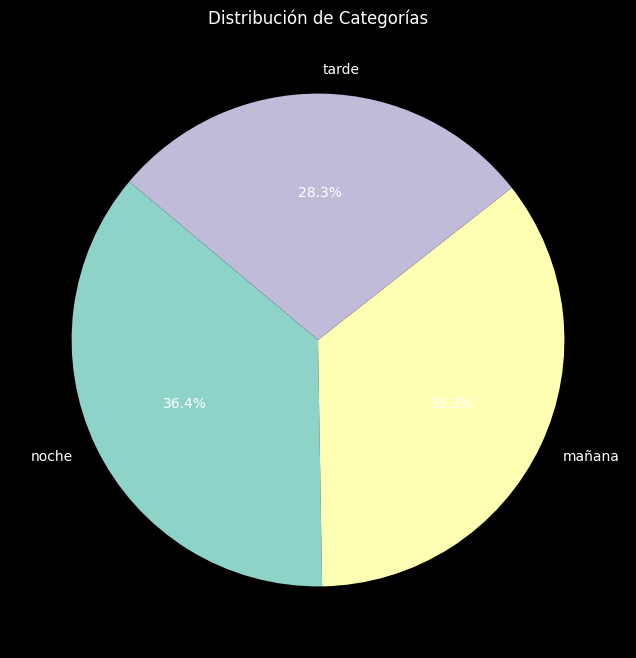

In [142]:
# Crear un gráfico de pie
conteo_categorias = df_filtrado['Periodo'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(conteo_categorias, labels=conteo_categorias.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Categorías')
plt.show()

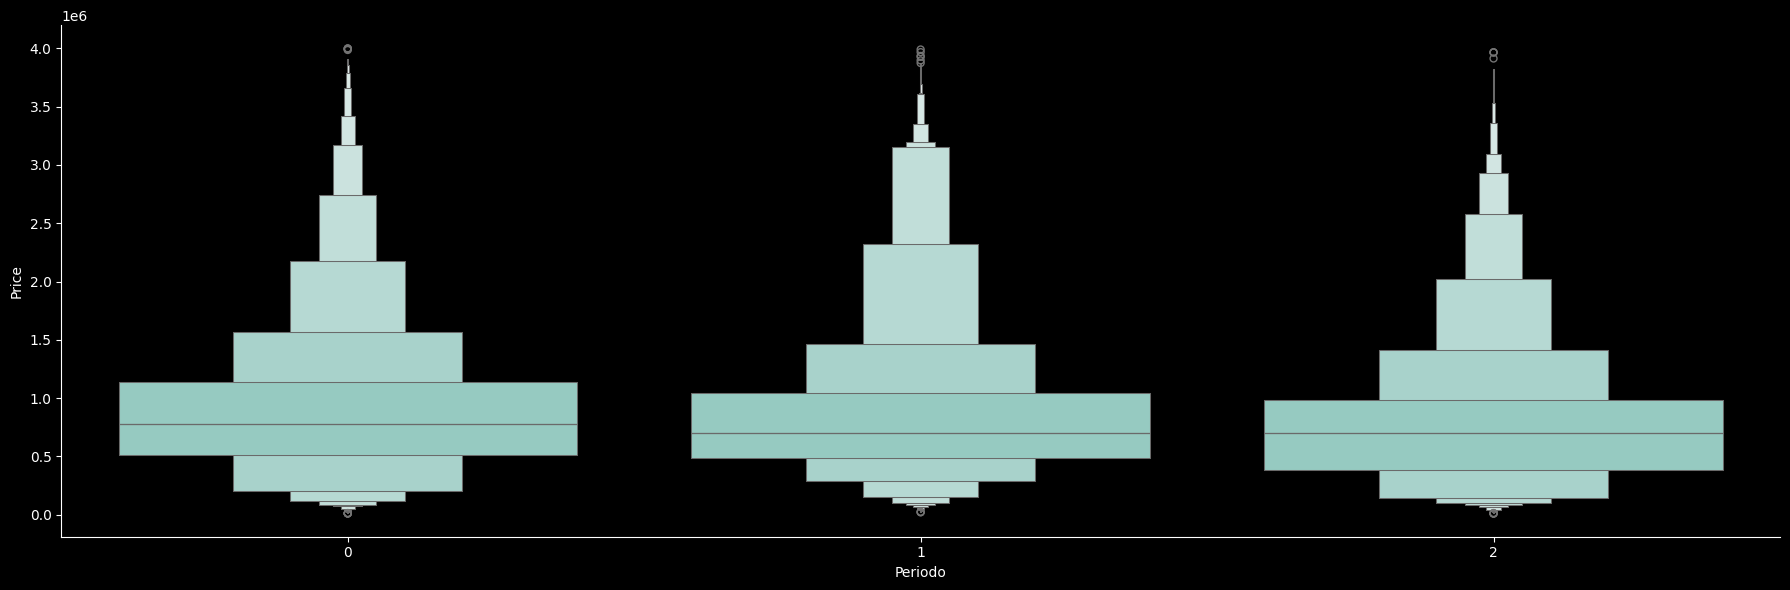

In [143]:
sns.catplot(y = "Price", x = "Periodo", data = dfives.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

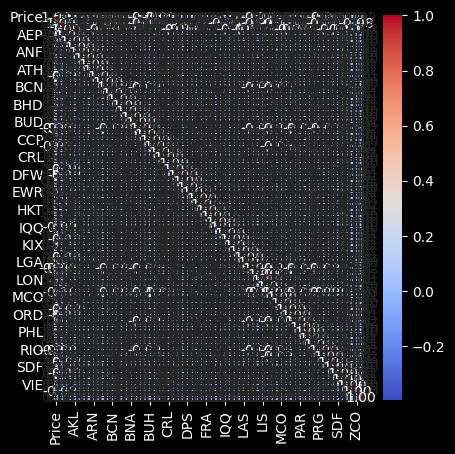

In [144]:
#Eliminar las variables categóricas
df_num1 = df_dest.select_dtypes(include='int64')

#Heatmaps con destinos
plt.figure(figsize=(5, 5))
sns.heatmap(df_num1.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

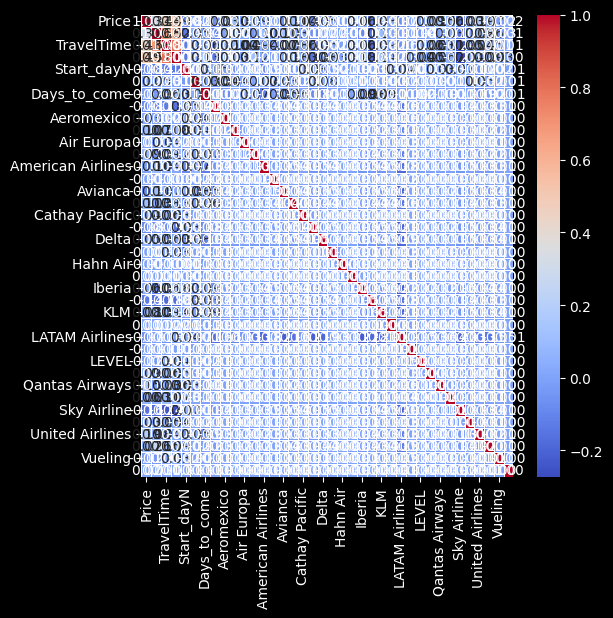

In [145]:
# Eliminar las variables categóricas
df_num2 = df_air.select_dtypes(include='number')

# Heatmap con aerolineas
plt.figure(figsize=(6, 6))
sns.heatmap(df_num2.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

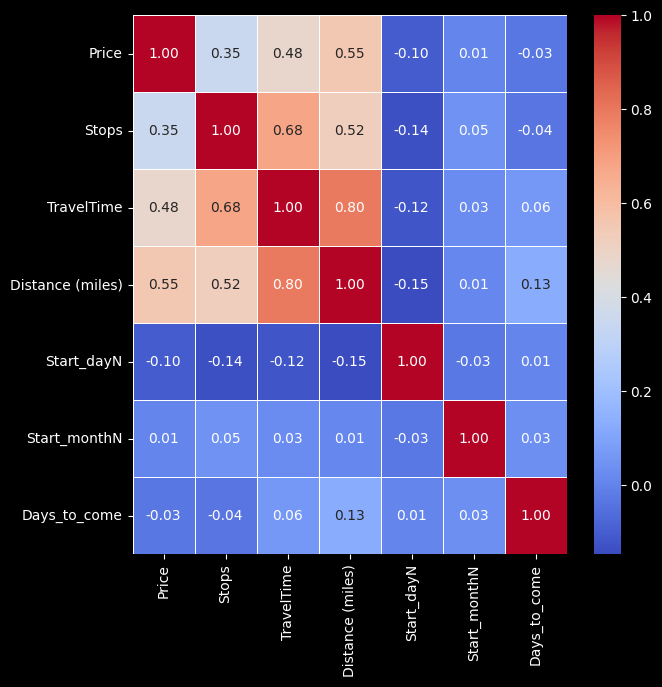

In [146]:
# Eliminar las variables categóricas
df_num = df_filtrado.select_dtypes(include='number')

#Heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

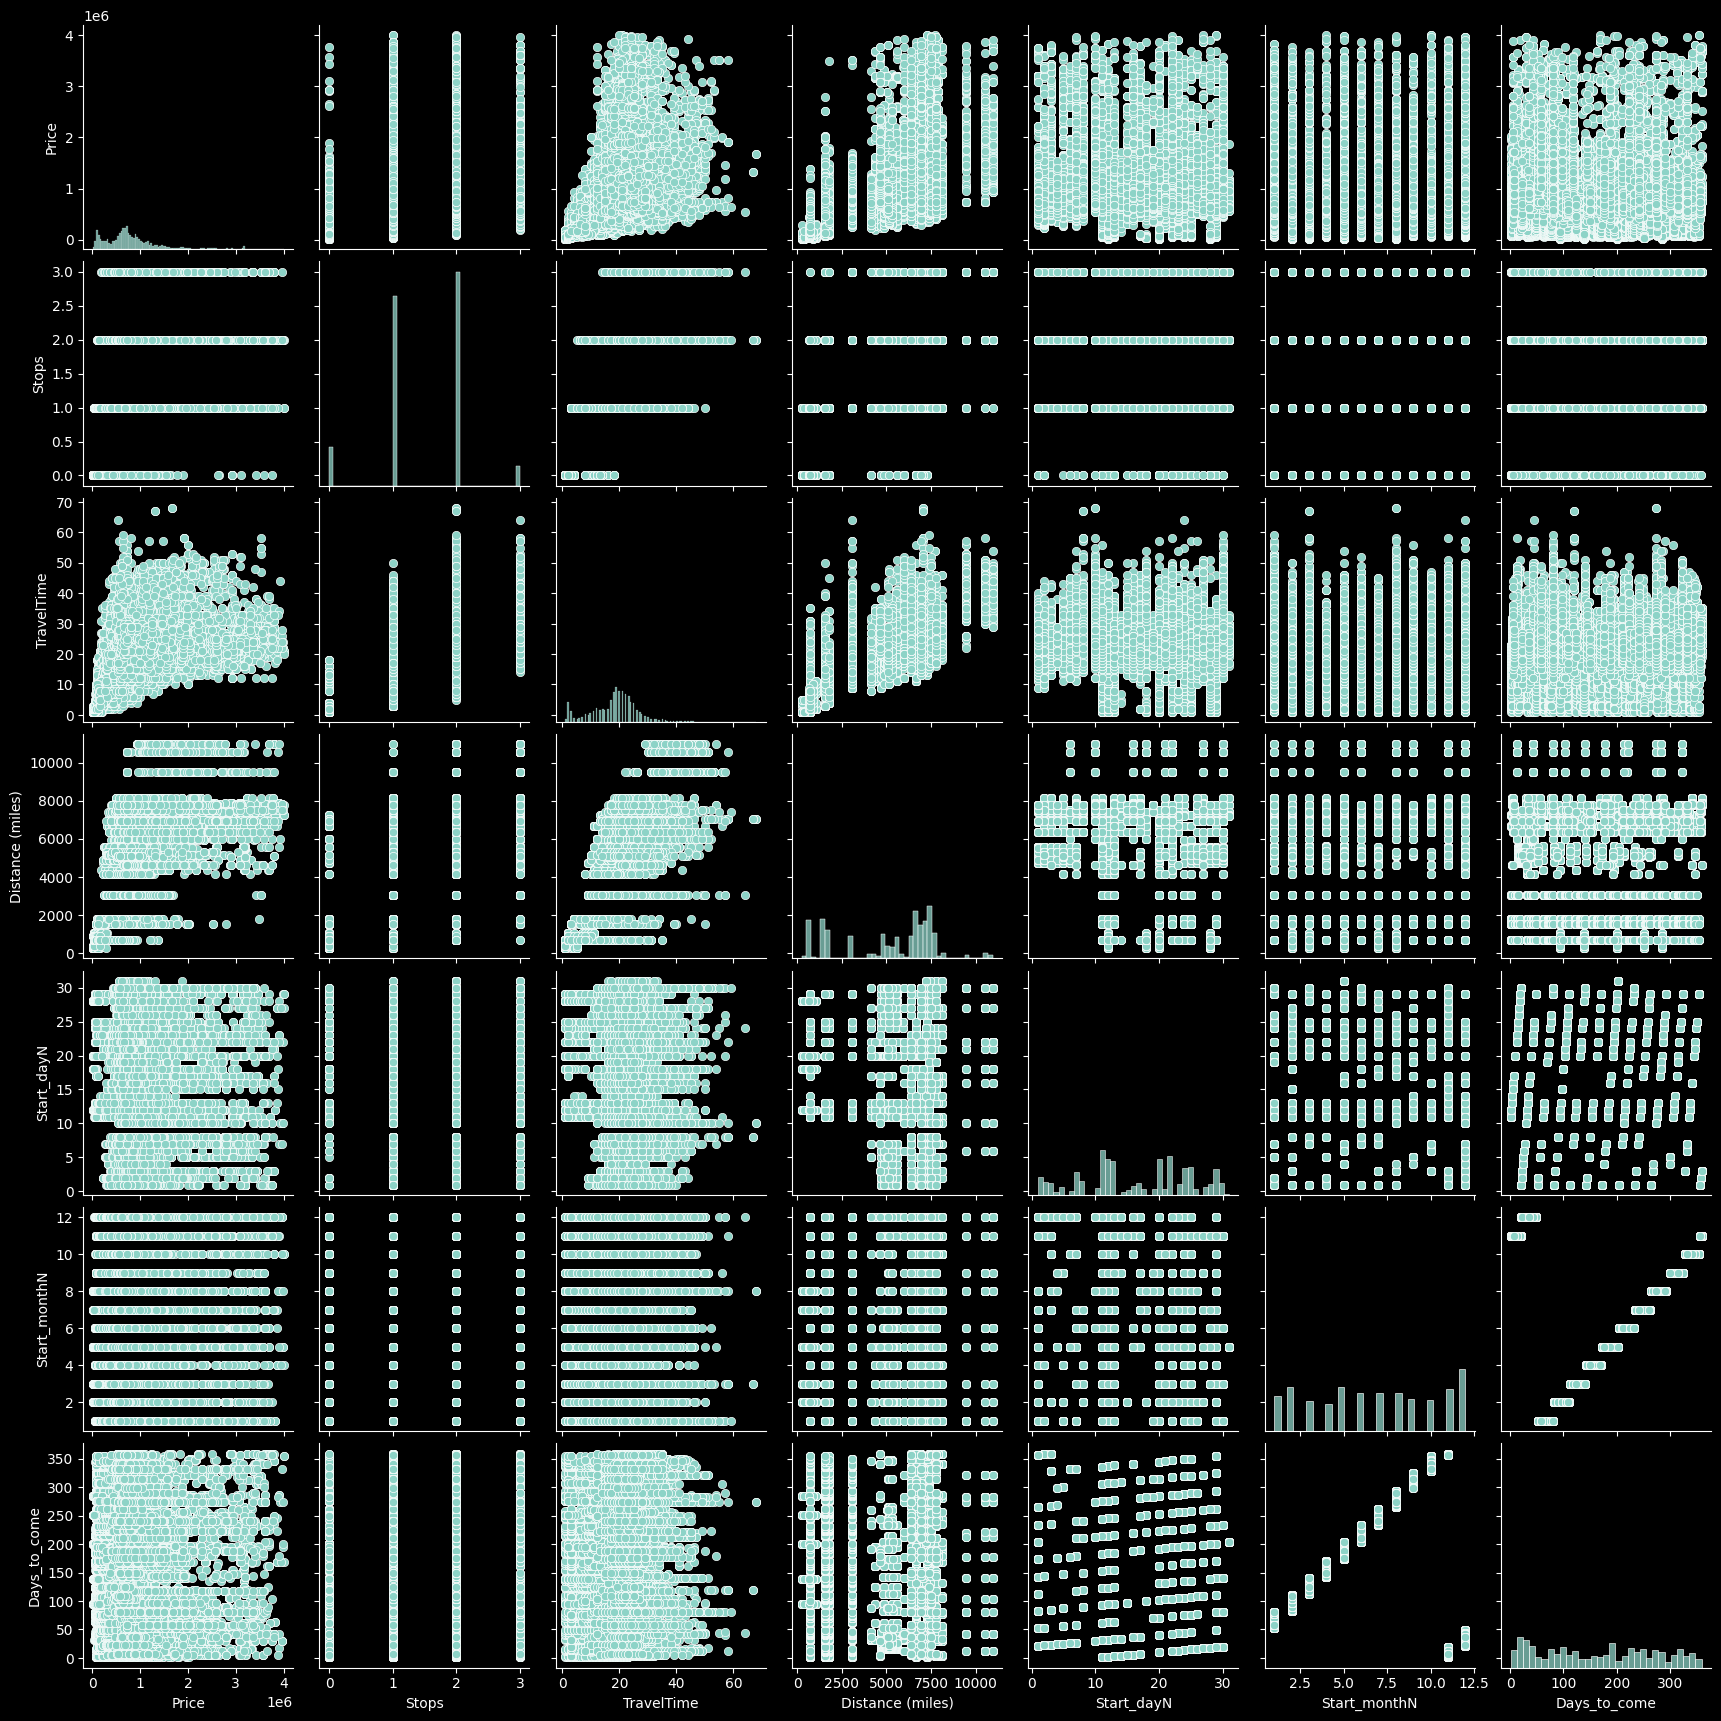

In [147]:
sns.pairplot(data=df_num)

# Modelos

In [148]:
#Definiendo X y Y
X = dfives.drop(["Price"],axis=1)
y = dfives["Price"]

In [149]:
# Spliting sample
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [150]:
#DecisionTree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [151]:
#DecisionTree
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred)
msr = mean_squared_error(y_test,y_pred)
sqrt(msr)

400755.3262612325

In [152]:
r2_score(y_test,y_pred)

0.6208918656550584

In [153]:
#RandomForest
model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [154]:
#RandomForest
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred)
msr = mean_squared_error(y_test,y_pred)
sqrt(msr)

301985.17562557035

In [155]:
r2_score(y_test,y_pred)

0.7847338493199161

In [ ]:
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Crear el modelo de Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Realizar la búsqueda de cuadrícula
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

In [ ]:
#RandomForest c/hiperparametros
model_grid = RandomForestRegressor(random_state = 42, max_depth= 15, min_samples_split= 2, n_estimators= 100)
model_grid.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=42)

In [ ]:
#RandomForest c7hiperparametros
y_pred = model_grid.predict(X_test)
mean_squared_error(y_test,y_pred)
msr = mean_squared_error(y_test,y_pred)
sqrt(msr)

336891.3219453152

In [ ]:
#Salvando los modelos
dump(model, open('../models/random_forest_regressor_default_42.pkl', 'wb'))
dump(model_grid, open('../models/random_forest_optimized_model.pkl', 'wb'))

# 1###############################

In [69]:
df_filtrado_usa = df_filtrado_usa.dropna()
df_filtrado_usa.columns[10:-10]



Index(['Air Canada', 'Air France', 'American Airlines', 'Arajet', 'Avianca',
       'British Airways', 'Copa Airlines', 'Delta', 'Hahn Air', 'JetSMART',
       'KLM', 'LATAM Airlines', 'Qantas Airways', 'Sky Airline',
       'United Airlines', 'Varias aerolíneas', 'WestJet', 'BOS', 'CLT', 'DEN',
       'DFW', 'DTW', 'EWR', 'HNL', 'IAD', 'JFK', 'LAS'],
      dtype='object')

In [70]:
X = df_filtrado_usa.drop(["Price"],axis=1)
y = df_filtrado_usa["Price"]

In [71]:
# spliting sample
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [72]:
# defining model RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor
model_usa = RandomForestRegressor( random_state=42)
model_usa.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [73]:
print(f'Entrenamiento { model_usa.score(X_train, y_train) : .3f}')
print(f'Validación { model_usa.score(X_test, y_test) : .3f}')

Entrenamiento  0.978
Validación  0.828


In [74]:
y_pred = model_usa.predict(X_test)

msr = mean_squared_error(y_test,y_pred)
sqrt(msr)

294553.54893116833

In [75]:
r2_score(y_test,y_pred)

0.8280388604687936

In [28]:
from pickle import dump
#save model
dump(model_usa, open('model_usa.sav','wb'))

# Hiperparametros

In [370]:
# hyperparams selection

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap' : [True, False]

}

# Crear el modelo de Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Realizar la búsqueda de cuadrícula
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [373]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor with the specified hyperparameters
rf_model = RandomForestRegressor(bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_model.predict(X_valid)

# Evaluate the model
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

print(f'R-squared: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

R-squared: 0.8087
Mean Squared Error: 96509495933.7211
Root Mean Squared Error: 310659.7752


# 1########

In [462]:

#one hot encoding month day
df_filtrado_usa = pd.get_dummies(df_filtrado_usa, columns=['Start_dayN'], prefix='Day')
df_filtrado_usa = pd.get_dummies(df_filtrado_usa, columns=['Start_monthN'], prefix='Month')
